In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
print(os.getcwd())

import platform
from matplotlib import font_manager, rc
import seaborn as sns # 데이터셋을 가져오기 위해 import

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family = font_name)
    
# 그래프에서 음수를 사용하기 위한 설정
plt.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# precision은 소수점은 과학적 표기법으로 변환할 자릿수를 설정
# 아래와 같이 하면 소수점 셋째 자리 밑으로는 과학적 표기법으로 표시
pd.options.display.precision = 3

C:\Users\USER\lg dx python


In [6]:
# 분할표 사용 - 범주형과 범주형 데이터의 분포를 확인
# 교차 테이블(crosstab 혹은 pivot table)을 사용

# 데이터 가져오기 및 확인
lc_loans = pd.read_csv('./data/lc_loans.csv')
#print(lc_loans.head())
#print(lc_loans['status'].value_counts())

# grade 별 status 의 갯수를 확인하기
# pivot_table 함수를 사용해서 pivot table로 표현
# 가로(index), 세로(columns), 사용할 함수, margin 을 지정
# margin 은 뷰 프로그래밍에서 컨텐츠와 컨텐츠 사이의 여백을 의미하고
# 통계 분야에서는 전체에 관련된 집계 데이터를 의미 - 여기서는 All
pv_table = lc_loans.pivot_table(index = 'grade', columns = 'status',
                               aggfunc = lambda x : len(x), margins = True)
print(pv_table)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [15]:
# 교차 분할 테이블에서 grade 의 비율 나타내기

# 테이블에서 all 을 제외한 데이터를 가져오기
DF = pv_table.copy().loc['A':'G']
# 각 데이터를 전체인 All 로 나눈 비율로 전환
DF.loc[:, 'Charged Off' : 'Late'] = DF.loc[:, 'Charged Off' : 'Late'].div(DF['All'], axis = 0)
# All 도 값이 아닌 비율로 전환
DF['All'] = DF['All'] / sum(DF['All'])

print(DF)

status  Charged Off  Current  Fully Paid   Late    All
grade                                                 
A             0.022    0.690       0.282  0.006  0.161
B             0.040    0.709       0.235  0.016  0.294
C             0.050    0.736       0.191  0.023  0.268
D             0.067    0.717       0.184  0.031  0.165
E             0.082    0.708       0.171  0.039  0.077
F             0.118    0.654       0.180  0.047  0.029
G             0.126    0.614       0.198  0.061  0.007


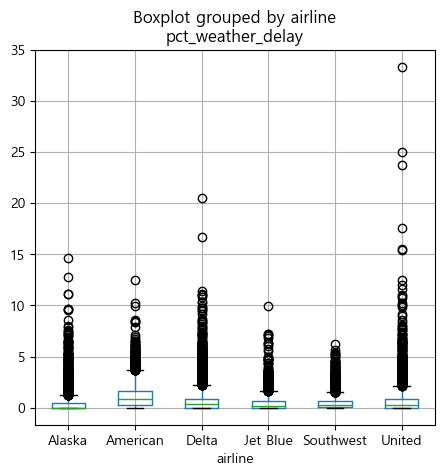

In [21]:
# 범주형과 수치형 데이터의 분포 확인 - boxplot 이용

# 데이터 가져오기 - 항공사 별 딜레이 발생 원인에 대한 데이터
# 딜레이 부분이 수치 데이터이기 때문에 위와 같이 교차 테이블로 나타내면
# 값이 너무 다양해서 표가 너무 커지게 됨
airline_stats = pd.read_csv('./data/airline_stats.csv')
#print(airline_stats.head())

# 일반적으로 by(그래프의 가로)에는 카테고리(여기서는 항공사)를 사용
# 값의 범위를 확인하기는 좋지만 값의 분포를 확인하기는 어려움
ax = airline_stats.boxplot(by = 'airline', column = 'pct_weather_delay',
                          figsize = (5, 5))

# 그래프 나타내기
plt.show()

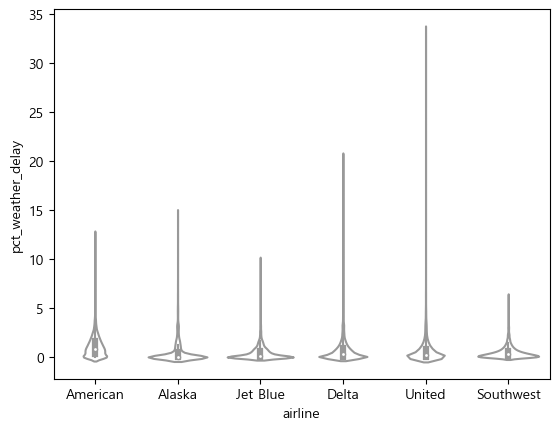

In [24]:
# 범주형과 수치형 데이터의 분포 확인 - violinplot 이용

# violinplot 을 사용하기 위한 import
import seaborn as sns

# violinplot 에 데이터를 주고 x 축, y 축을 지정
sns.violinplot(data = airline_stats, x = 'airline', y = 'pct_weather_delay',
              color = 'white')
# 이상치를 확인할 수 있으며 데이터의 분포도 확인 가능

plt.show()

### 검사 시약 문제
##### 한 제약사에서 환자가 특정한 병에 걸렸는지 확인하는 시약을 만들었는데 그 병에 걸린 환자에게 시약을 테스트한 결과 99% 정확도를 나타냄
##### 이 병은 전체 인구 중 0.2%가 걸림
#####  이 병에 걸리지 않은 사람에게 시약 테스트를 했을 때 양성으로 나올 확률도 필요 - 5%
#####  일반적인 사람이 이 시약을 테스트한 결과 양성으로 나타났을 때 실제로 이 병에 걸렸을 확률은?

In [25]:
!pip install pgmpy

     ---------------------------------------- 1.9/1.9 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00


In [26]:
# 병에 걸릴 확률과 병에 걸리지 않을 확률을 생성

# 사용할 패키지 import
from pgmpy.factors.discrete import TabularCPD

# 조건부 확률 구하기
# 확률 변수의 이름, 경우의 수, 조건부 확률 배열 순서로 작성
# 2 는 발생할 수 있는 경우의 수(2개)
# 조건부 확률 배열은 서로 독립적이어야 하기 때문에 다른 [] 로 묶음
cpd_X = TabularCPD('X', 2, [[0.998], [0.002]])
print(cpd_X)

+------+-------+
| X(0) | 0.998 |
+------+-------+
| X(1) | 0.002 |
+------+-------+


In [32]:
# 진단 시약의 판단 여부를 대입해서 확률 모형을 생성
# 정상인 경우 정상으로 판단할 확률은 95%, 잘못 판단할 확률은 5%
# 병에 걸린 경우 양성으로 판단할 확률은 99%, 음성 확률은 1%

cpd_Y_on_X = TabularCPD('Y', 2, np.array([[0.95, 0.01], [0.05, 0.99]]),
                       evidence = ['X'], evidence_card = [2])
print(cpd_Y_on_X)

+------+------+------+
| X    | X(0) | X(1) |
+------+------+------+
| Y(0) | 0.95 | 0.01 |
+------+------+------+
| Y(1) | 0.05 | 0.99 |
+------+------+------+


In [37]:
# 모델 생성

from pgmpy.models import BayesianModel

model = BayesianModel([('X', 'Y')])
model.add_cpds(cpd_X, cpd_Y_on_X)

# 모델이 정상적으로 만들어졌는지 확인
#print(model.check_model()) # 성공하면 True

# 양성으로 나왔을 때의 확률
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)
# Y 값이 1이면 양성으로 나왔을 때 병에 걸리지 않았을 확률과 병에 걸렸을 확률
# Y 값이 0이면 음성으로 나왔을 때 병에 걸리지 않았을 확률과 병에 걸렸을 확률
print(inference.query(['X'], evidence = {'Y' : 1 }))
# 병에 걸렸을 때(양성일 때) 실제로 걸렸을 확률은 0.0382
# 음성으로 나올 때 실제로 병에 걸렸을 확률은 0

+------+----------+
| X    |   phi(X) |
+======+==========+
| X(0) |   1.0000 |
+------+----------+
| X(1) |   0.0000 |
+------+----------+


In [2]:
import scipy as sp
import scipy.stats

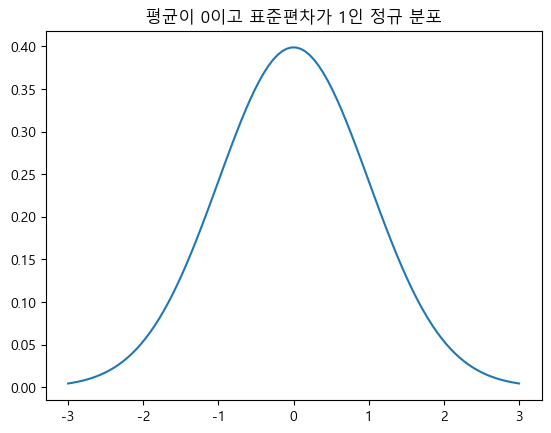

In [42]:
# 정규 분포 만들기

# 정규 분포를 만들기 위해서는 평균과 표준 편차가 필요
mu = 0 # 평균은 0
std = 1 # 표준편차는 1

# 정규 분포 객체 생성
reg = sp.stats.norm(mu,std)
# 샘플 데이터 100개 생성 - -3 ~ +3 사이
sample_data = np.linspace(-3, 3, 100)

plt.plot(sample_data, reg.pdf(sample_data))
plt.title('평균이 0이고 표준편차가 1인 정규 분포')
plt.show()

In [46]:
# 데이터 샘플링
dat = reg.rvs(100)
print(dat)

[-1.799 -0.035  0.082  0.435  0.766 -1.137  1.381 -1.149  0.04   0.355
 -1.132  0.394  0.136 -0.77  -0.05   0.094  1.032 -0.807 -0.476  0.97
  0.217 -0.876  0.217  0.586 -1.94   0.717 -0.205  0.544 -0.078  0.4
 -1.282  0.817  0.644 -0.005  1.123  0.154  1.236  1.168 -1.451 -0.423
 -0.78  -1.308 -0.642  2.357 -1.262 -1.269  0.654  1.197 -0.316  0.282
  0.776  0.093  0.147 -0.471  0.433 -0.232  0.082  0.869 -1.318 -0.871
  0.221  1.054  0.415  0.279 -0.962  0.838  0.915  0.041  0.653  0.519
 -0.144 -0.953  0.95   0.15   0.734 -1.086 -0.042 -1.213  1.564  0.381
  0.624  2.047 -1.812  0.556  0.211  0.855  1.181 -1.614  0.388  0.175
  1.201  1.574  1.755 -0.527 -0.851  0.074 -1.263  0.101 -1.727 -0.536]


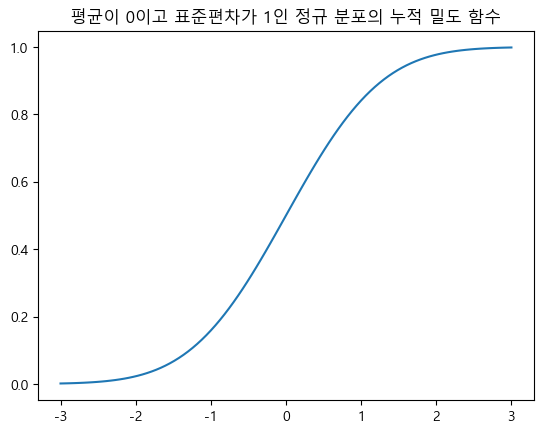

In [47]:
# 누적 밀도 함수
plt.plot(sample_data, reg.cdf(sample_data))
plt.title('평균이 0이고 표준편차가 1인 정규 분포의 누적 밀도 함수')
plt.show()

In [48]:
!pip install pandas-datareader

     -------------------------------------- 109.5/109.5 kB 6.2 MB/s eta 0:00:00


In [3]:
# 주가 정보 가져오기

# 사용할 패키지 import
import pandas_datareader.data as web
import datetime

# 날짜 설정
start = datetime.datetime(2023, 1, 1)
end = datetime.datetime(2023, 8, 21)

# 데이터를 가져올 국가의 주가 지수 코드 - 미, 일, 유럽, 한
symbols = ['SPASTT01USM661N', 'SPASTT01JPM661N', 'SPASTT01EZM661N', 'SPASTT01KRM661N']

# 빈 DataFrame 생성
data = pd.DataFrame()

# 반복하면서 데이터 가져오기
for symbol in symbols:
    data[symbol] = web.DataReader(symbol, data_source = 'fred',
                              start = start, end = end)[symbol]
    
print(data)

            SPASTT01USM661N  SPASTT01JPM661N  SPASTT01EZM661N  SPASTT01KRM661N
DATE                                                                          
2023-01-01          147.018          123.796          123.450          117.609
2023-02-01          148.239          127.957          127.930          121.835
2023-03-01          141.135          128.076          125.886          120.195
2023-04-01          145.176          129.986          129.351          125.462
2023-05-01          142.583          136.609          128.107          125.493
2023-06-01          145.834          145.423          127.833          129.259
2023-07-01          150.752          146.421          129.136          128.997


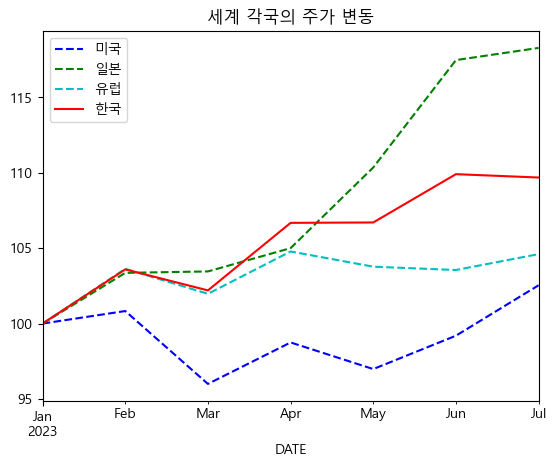

In [54]:
# 주가 정보로 그래프 그리기

# 컬럼 이름 수정
data.columns = ['미국', '일본', '유럽', '한국']
# 가장 앞의 데이터를 기준으로 백분율로 표현
data = data/data.iloc[0] * 100
# 그래프의 스타일 지정
# b, g, c, r 은 색상, '--'는 점선으로 표시
styles = ['b--', 'g--', 'c--', 'r']

data.plot(style = styles)
plt.title('세계 각국의 주가 변동')
plt.show()


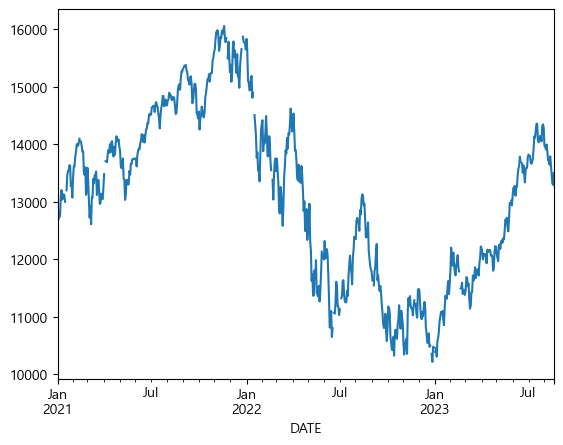

In [58]:
# 나스닥에 대한 주가 정보 그리기
data = pd.DataFrame()
symbol = 'NASDAQCOM'
data[symbol] = web.DataReader(symbol, data_source = 'fred',
                              start = '2021-01-01', end = end)[symbol]

data.plot(legend = False)
plt.show()

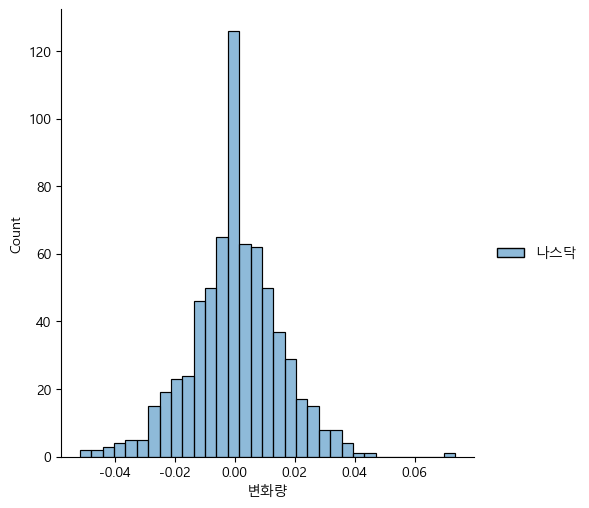

In [67]:
# 일차별 주가의 차이

# pct_change 함수 사용
# 처음 하루는 없으므로 dropna 적용
daily_diff = data.pct_change().dropna()
daily_diff.columns = ['나스닥']
#print(daily_diff)

# 일차별 차이를 그래프로 출력
# 정규 분포와 유사한 그래프가 나타남
sns.displot(daily_diff, kde = False)
plt.xlabel('변화량')
plt.show()

In [68]:
!pip install yfinance

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.



     ---------------------------------------- 65.3/65.3 kB 3.4 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 6.4 MB/s eta 0:00:00
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1


In [71]:
# 특정한 회사의 주가 가져오기

import yfinance as yfin

yfin.pdr_override()

# 네이버 주가 정보 가져오기
naver = web.get_data_yahoo('035420.ks')
print(sam)


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2002-10-29    1797.725    1797.725    1797.725    1797.725    1753.010   
2002-10-30    2012.226    2012.226    1989.755    2012.226    1962.176   
2002-10-31    2042.869    2091.898    1865.140    1912.125    1864.565   
2002-11-01    1961.154    2022.440    1724.182    1793.639    1749.026   
2002-11-04    1777.296    1789.553    1660.853    1703.753    1661.375   
...                ...         ...         ...         ...         ...   
2023-08-17  221000.000  222000.000  216000.000  218000.000  218000.000   
2023-08-18  213500.000  217500.000  211000.000  212500.000  212500.000   
2023-08-21  213000.000  218000.000  213000.000  214500.000  214500.000   
2023-08-22  218000.000  224500.000  217000.000  221000.000  221000.000   
2023-08-23  222000.000  222000.000  215500.

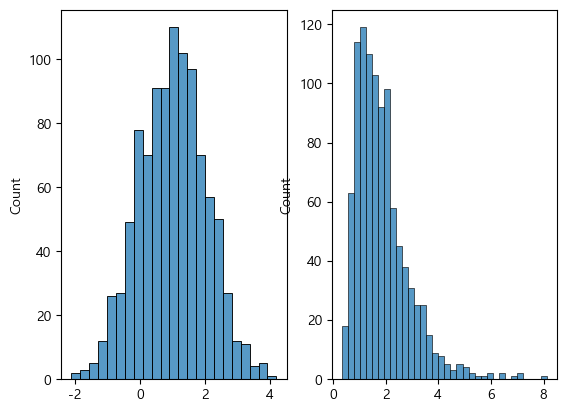

In [74]:
# 정규 분포와 로그 정규 분포 모형 비교

mu = 1
rv = sp.stats.norm(loc = mu)

# 데이터 생성
x1 = rv.rvs(1000)
s = 1/2
x2 = np.exp(s * x1)

fig, ax = plt.subplots(1, 2)
sns.histplot(x1, kde = False, ax = ax[0]) # 정규 분포
sns.histplot(x2, kde = False, ax = ax[1]) # 로그 정규 분포
# 평균인 1을 기준으로 보면 로그 정규 분포는 좌우가 대칭이 아님

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

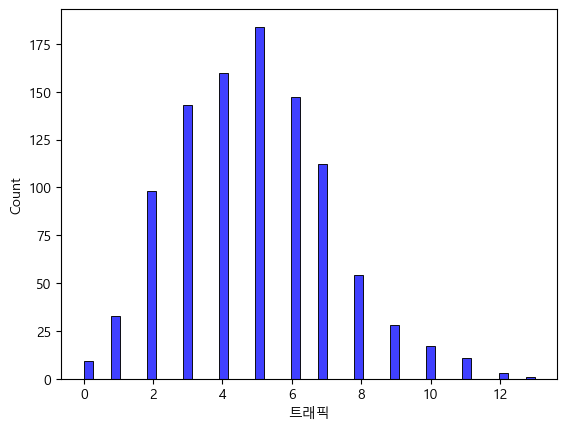

In [14]:
# 푸아송 분포 만들기 - 트래픽 문제

mu = 5 # 하루 평균 트래픽

# 푸아송 분포에 해당하는 데이터 생성
# 평균과 사이즈를 지정
data_poisson = sp.stats.poisson.rvs(mu , size = 1000)

# 데이터를 가지고 그래프 그리기
# 그려진 그래프를 가지고 신뢰도(전체 중 비율)를 만족하는 트래픽 범위를 알 수 있음
ax = sns.histplot(data_poisson, bins = 50, color = 'blue', kde = False)
plt.xlabel('트래픽')
plt.show

In [20]:
import random

# 데이터 집단 생성
data = [1, 2, 3, 4, 5 ,6 ,7, 8]

# 복원 추출 - 같은 값이 또 나올 수 있음
for i in range(7):
    print(data[random.randint(0, len(data) -1)])
    
# 비복원 추출 
# 반복문을 사용하지 않으며 중복이 없음
not_b = random.sample(data, 6)
print(not_b)

1
3
5
5
6
2
8
[5, 8, 7, 4, 6, 1]


In [32]:
# 임의의 데이터 추출 - numpy

# 데이터 생성
data = ['123', '253', '256', '623', 'park', 'qkr', 'oqiwe']

# 데이터에서 6개의 임의의 데이터를 복원 추출
print(np.random.choice(data, size = 6, replace = True))

# 데이터에서 비복원 추출
print(np.random.choice(data, size = 6, replace = False))

# 8대2 비복원 추출 - ML에서 일반적으로 훈련 데이터와 검증 데이터를 분리하는 방식
size = int(len(data) * 0.8)
sample = np.random.choice(data, size = size, replace = False)
print(sample)

# 뽑히지 않은 20% 데이터를 validation에 추가
val = []
for item in data:
    if item not in sample:
        val.append(item)
    
print(val)

['oqiwe' 'park' '123' '256' '253' 'oqiwe']
['253' '123' 'oqiwe' 'qkr' 'park' '256']
['623' 'park' '253' '256' 'oqiwe']
['123', 'qkr']


In [33]:
# 가중치 부여하여 샘플 추출 - 층화 추출
# 분류 분석에서 이 속성이 Target 으로 사용되는 경우에는
# 데이터의 갯수를 파악한 후 층화 추출을 고려해봐야 함

# 각 데이터에 대해 가중치(확률)를 부여
print(np.random.choice(data, size = 6, replace = True, 
                       p = [0.1, 0.1, 0.15, 0.35, 0.1, 0.1, 0.1]))

['623' '256' 'oqiwe' '623' '623' 'qkr']


In [45]:
# DataFrame 에서의 샘플링
DF = pd.DataFrame(np.arange(0, 16).reshape(4,4))
# n 을 통해 샘플의 갯수 지정
print(DF.sample(2)) 
# frac 을 통해 샘플의 비율 지정
print(DF.sample(frac = 0.3))

# Series 에서의 샘플링
DF = pd.Series(['1', '2', '3', '4', '5', '6'])
#print(DF)
print(DF.sample(3))


0    1
2    3
3    4
dtype: object
   0  1   2   3
2  8  9  10  11
0  0  1   2   3
   0  1  2  3
1  4  5  6  7


In [55]:
# 30개의 데이터 생성
data1 = np.arange(30).reshape(10, 3)
#print(data[3])
#print(data)

data2 = np.arange(20).reshape(10, 2)

In [57]:
# 순차적 분할 - 데이터를 순서대로 분할

# shuffle 옵션을 False 로 설정
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1, data2,
                                                   test_size = 0.2,
                                                   shuffle = False,
                                                   random_state = 21)

# 8대2 비율로 분할됨 - 마지막 6(3x2)개 데이터가 X_test 로 분할됨
print(X_train.shape) # (8, 3)
print(X_test.shape) # (2, 3)
print(X_test)

(8, 3)
(2, 3)
[[24 25 26]
 [27 28 29]]


In [68]:
# 랜덤 추출
# 랜덤 추출을 사용해서 실제 훈련에 사용한다면 랜덤 시드는 고정시켜야 함
# 시드를 고정하지 않으면 선택된 데이터에 따라 다른 모델이 생성되고
# 검증에 사용하는 데이터도 랜덤하게 생성되어서 계속 달라지게 됨

# shuffle 옵션을 True 로 설정
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1, data2,
                                                   test_size = 0.2,
                                                   shuffle = True,
                                                   random_state = 21)
# 8:2 비율은 유지하지만 X_test 로 분류되는 데이터는 순서와 관계 없음
# 지금은 seed 를 고정해서 여러 번 실행해도 같은 결과를 보임
print(X_train.shape) # (8, 3)
print(X_test.shape) # (2, 3)
print(X_train)

(8, 3)
(2, 3)
[[21 22 23]
 [ 9 10 11]
 [15 16 17]
 [18 19 20]
 [ 0  1  2]
 [12 13 14]
 [24 25 26]
 [27 28 29]]


In [69]:
# 층화 무작위 추출

# 데이터 생성
X = np.arange(20).reshape(10, 2)
y = np.arange(10).reshape(10)
print(X)
print(y)

# 층을 구분해서 높은 값이 분류에서 더 잘 나오도록
grep = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# 층화 무작위 추출 - stratify 적용
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   shuffle = True,
                                                    stratify = grep,
                                                   random_state = 21)

# X_train 에 높은 값들이 자주 등장
print(X_train.shape) # (7, 2)
print(X_test.shape) # (3, 2)
print(X_train)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
[0 1 2 3 4 5 6 7 8 9]
(7, 2)
(3, 2)
[[18 19]
 [ 8  9]
 [ 0  1]
 [16 17]
 [ 4  5]
 [10 11]
 [12 13]]


In [78]:
# 데이터 불러오기
DF = pd.read_csv('./data/coffee_dataset.csv')

# 실제 데이터의 갯수 확인 - 2974개
#DF.info()

# 200개의 데이터 샘플링
DF_sample = DF.sample(200)
#DF_sample.info() # 200개
DF_sample.head()


,user_id,age,drinks_coffee,height
947,1949,>=21,False,73.659
1051,2686,>=21,True,67.206
770,5447,<21,False,63.467
88,5398,<21,False,66.588
1897,2123,<21,True,63.531


In [77]:
# 커피를 마시는 사람과 커피를 마시지 않는 사람의 키 평균 차이

# 반복 횟수 - 커질수록 시간이 오래 걸리지만 추정이 정확해짐
iterNum = 1000

diffHeightList = []

# 샘플링한 데이터에서 복원 추출을 200회 진행하고 그때마다 키의 평균을 계산
for _ in range(iterNum):
    bootSample = DF_sample.sample(200, replace = True) # 복원 추출
    # 커피를 마시지 않는 사람의 평균 키
    nonCoffeeHeightMean = bootSample[bootSample['drinks_coffee'] == False].height.mean()
    # 커피를 마시는 사람의 평균 키
    coffeeHeightMean = bootSample[bootSample['drinks_coffee'] == True].height.mean()
    # 키의 차이 구하기
    diffHeightList.append(nonCoffeeHeightMean - coffeeHeightMean)

print(len(diffHeightList)) # 반복 횟수
print(sum(diffHeightList)/len(diffHeightList)) # 평균 키 차이

# 신뢰구간 99% 인 평균 키 차이에 대한 신뢰구간
# 각각 1%, 99% 에 대한 신뢰 구간을 나타냄 - 1% ~ 99% 사이의 값
# 아래의 값들 사이의 데이터라면 우연히 그럴 수 있는 데이터지만
# 그 범위 바깥으로 나가는 데이터는 유의미한 데이터
# 약 -2.392 ~ -0.059
print(np.percentile(diffHeightList, 1.0), np.percentile(diffHeightList, 99))

1000
-1.258787085007682
-2.392268875390899 -0.05955310405264894


In [80]:
# 21세 이상과 미만의 키 차이

diffHeightList = []

for _ in range(iterNum):
    bootSample = DF_sample.sample(200, replace = True) # 복원 추출
    # 21세 이상인 사람의 평균 키
    over21HeightMean = bootSample[bootSample['age'] == '>=21'].height.mean()
    # 21세 미만인 사람의 평균 키
    under21HeightMean = bootSample[bootSample['age'] == '<21'].height.mean()
    # 키의 차이 구하기
    diffHeightList.append(over21HeightMean - under21HeightMean)

print(sum(diffHeightList)/len(diffHeightList)) # 평균 키 차이

# 신뢰구간 99% 인 평균 키 차이에 대한 신뢰구간
# 약 3.263 ~ 4.914
print(np.percentile(diffHeightList, 1.0), np.percentile(diffHeightList, 99))

4.0472708343839265
3.2637051570928257 4.91499574815036


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import 